# Using pyoptsparse

opting siff

In [1]:
import pyoptsparse
import numpy
import matplotlib.pyplot as plt
import scipy
import scipy.sparse
import femGTopo

Nx = 100
Ny = 100


vset = 0.1
MaxVM=100000

pVM = 1000
femF = femGTopo.isoGridFem2DOptFun(pVM, Nx, Ny, 1., 1.)
fix = numpy.zeros((Ny + 1, Nx + 1))
fx = numpy.zeros_like(fix)
fy = numpy.zeros_like(fix)
fix *= numpy.nan
# fix[0:5, 0:50] = 0
# fix[-1:-6:-1, 0:50] = 0
fix[:,0] = 0
# fx[-1, int(numpy.ceil(Nx*0.8)) :-1] = 1.0 / Nx
# fx[:,-1] = 1.0 / Ny # right side
fy[-1, :] = 1.0 / Nx
rho = numpy.ones((Ny, Nx)) * 0.5


femF.SetElemMat()
femF.setBCs(fix, fx, fy)
femF.AssembleKbLocal()
femF.Eval(rho)
print(femF.PI_VM)

def objfuncs(xdict):
    rho = numpy.array(xdict["rho"]).reshape((Ny, Nx),order="C")
    femF.EvalVM(rho)
    

    funcs = {}
    funcs["PI_AB"] = femF.PI_AB
    funcs["PI_VM"] = femF.PI_VM
    funcs["vol"] = numpy.mean(rho)

    fail = False
    # print("===Call obj")
    return funcs, fail

def sensfuncs(xdict, fdict):
    sens = {}
    rho = numpy.array(xdict["rho"]).reshape((Ny, Nx),order="C")
    femF.EvalVMdiff(rho)
    femF.FilterABdiff()
    
    sens["PI_VM"] = {}
    sens["PI_VM"]["rho"] = femF.dPI_VMdrho.reshape((1,Nx*Ny),order="C")

    sens["PI_AB"] = {}
    sens["PI_AB"]["rho"] = femF.dPI_ABdrho.reshape((1,Nx*Ny),order="C")
    # print("===Call sens")

    
    # plt.figure(2)
    # plt.clf()
    # plt.pcolor(opter.femF.xcm, opter.femF.ycm, opter.rho, shading='auto')
    # plt.colorbar()
    # plt.axis("equal")
    # f = plt.gcf()
    # f.set_size_inches(8,4)
    # display.display(plt.gcf())
    # display.clear_output(wait=True)

    return sens


opt = pyoptsparse.Optimization("FEMGTOPO",objFun=objfuncs)

opt.addVarGroup(
    "rho",
    nVars=Nx * Ny,
    varType="c",
    value=vset,
    lower=0.0,
    upper=1.0,
    scale=1.0,
    offset=0.0,
)

opt.addConGroup(
    "vol",
    nCon=1,
    lower=vset,
    upper=vset,
    scale=1.0,
    linear=True,
    jac={"rho": numpy.ones((1, Nx * Ny))/(Nx*Ny)},
)

opt.addConGroup(
    "PI_VM",
    nCon=1,
    lower=None,
    upper=MaxVM,
    scale=1.0,
    linear=False,
)

opt.addObj(name="PI_AB" )

print(opt)

options = {}
options['print_level']=5
options['tol'] = 1e-2
options['max_iter'] = 100
opter = pyoptsparse.OPT("IPOPT", options = options)

/home/harry/anaconda3/envs/DL/lib/python3.9/site-packages/pyoptsparse/pyOpt_MPI.py:68: UserWarning: mpi4py could not be imported. mpi4py is required to use the parallel gradient analysis and parallel objective analysis for non-gradient based optimizers. Continuing using a dummy MPI module from pyOptSparse.
  warnings.warn(warn)


144.86347171807165


Optimization Problem -- FEMGTOPO
    Objective Function: objfuncs


   Objectives
      Index  Name             Value
          0  PI_AB     0.000000E+00

   Variables (c - continuous, i - integer, d - discrete)
      Index  Name       Type      Lower Bound            Value      Upper Bound     Status
          0  rho_0         c     0.000000E+00     1.000000E-01     1.000000E+00           
          1  rho_1         c     0.000000E+00     1.000000E-01     1.000000E+00           
          2  rho_2         c     0.000000E+00     1.000000E-01     1.000000E+00           
          3  rho_3         c     0.000000E+00     1.000000E-01     1.000000E+00           
          4  rho_4         c     0.000000E+00     1.000000E-01     1.000000E+00           
          5  rho_5         c     0.000000E+00     1.000000E-01     1.000000E+00           
          6  rho_6         c     0.000000E+00     1.000000E-01     1.000000E+00           
          7  rho_7         c     0.0000

In [2]:
sol = opter(opt, sens=sensfuncs)


List of user-set options:

                                    Name   Value                used
                        file_print_level = 5                     yes
                   hessian_approximation = limited-memory        yes
                           linear_solver = mumps                 yes
                                max_iter = 200                   yes
                             output_file = IPOPT.out             yes
                             print_level = 5                     yes
                      print_user_options = yes                   yes
                                      sb = yes                   yes
                                     tol = 0.01                  yes
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:    10000
Number of nonzeros in inequality constraint Jacobian.:    10000
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of va

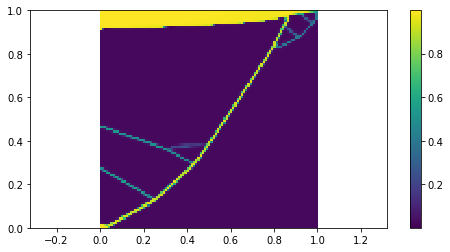

In [3]:
dvdict = sol.getDVs()
rho = dvdict['rho'].reshape((Ny,Nx))
plt.figure(2)
plt.clf()
plt.pcolor(femF.xcm, femF.ycm, rho, shading='auto')
plt.colorbar()
plt.axis("equal")
f = plt.gcf()
f.set_size_inches(8,4)


In [4]:
import scipy.signal

import numpy

window = numpy.ones((3,3))
data = numpy.eye(10,10)
filt = scipy.signal.correlate2d(data,window, mode = 'same', boundary='symm')
filt

filt[:,-1:-5:-1]
# a = femF.dPI_VMdrho

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 2.],
       [0., 1., 2., 3.],
       [1., 2., 3., 2.],
       [3., 3., 2., 1.],
       [5., 3., 1., 0.]])